In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
import ast
from scipy import stats

In [3]:
pd.set_option('display.max_rows', 100)

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader

In [5]:
cwd = os.getcwd()
print(cwd)
cwd_parent = os.path.abspath(os.path.join(cwd, os.pardir))
# cwd_parent = os.path.abspath(os.path.join(cwd, '../../'))
print(cwd_parent)

sys.path.append(cwd_parent)

/cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/notebooks
/cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git


In [6]:
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.hyphelperflat import *
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN
from ogb.graphproppred import Evaluator

In [7]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [10]:
report_available_cuda_devices()

number of GPUs available: 5
cuda:0, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, 

In [11]:
n_gpu = torch.cuda.device_count()
n_gpu

5

In [12]:
fdtype = torch.float32

In [13]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.11.0+cu115
CUDA: 11.5


### Preparing dataset 

In [14]:
# options: 
# 'total_thresh' + 4,3,2
# 'loewe_thresh', 'hsa_thresh', 'bliss_thresh', 'zip_thresh' + 1

score = 'total_thresh'
score_val = 4

In [15]:
DSdataset_name = f'DrugComb_{score}_{score_val}'

data_fname = 'data_v1' # v2 for baseline models

In [16]:
df_drugcomb = pd.read_csv(f'../data/preprocessing/drugcomb_{score}_{score_val}.csv')
df_drugcomb

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,AS601245,717906-29-1,A-673,684052,C1=CC=C2C(=C1)N=C(S2)C(C#N)C3=NC(=NC=C3)NCCC4=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,CHEMBL166161,717906-29-1,A-673,684052,COC1(CCN(CC1)CCC2=CNC3=C2C=C(C=C3)F)CS(=O)C4=C...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
...,...,...,...,...,...,...,...
25752,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0
25753,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0
25754,Sapitinib,Vorinostat,VM-CUB-1,909780,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,0
25755,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1


In [17]:
df_rma_landm = pd.read_csv('../data/preprocessing/df_rma_landm.tsv', sep="\t")
df_rma_landm

,Unnamed: 0,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
2,19,BAD,BCL2-associated agonist of cell death [Source:...,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
3,20,LAP3,leucine aminopeptidase 3 [Source:HGNC Symbol;A...,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
4,28,SNX11,sorting nexin 11 [Source:HGNC Symbol;Acc:14975],4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,17083,PLEKHM1,"pleckstrin homology domain containing, family ...",6.167946,5.271099,5.784561,7.587263,6.479184,5.700915,6.617353,...,6.714959,6.368537,8.252268,6.436644,6.436742,5.551436,5.634834,7.083564,5.776658,6.306988
904,17400,MIF,macrophage migration inhibitory factor (glycos...,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
905,17444,PRAF2,"PRA1 domain family, member 2 [Source:HGNC Symb...",5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205
906,17575,LYN,v-yes-1 Yamaguchi sarcoma viral related oncoge...,5.892532,4.580184,6.482469,7.094195,7.932918,7.333405,10.455397,...,4.914232,9.453552,3.218797,4.073831,6.355383,8.348965,7.579339,4.456322,5.857488,3.013612


In [18]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

path_current_dir /cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/deepadr
path_current_dir /cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/deepadr
path_current_dir /cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/deepadr


In [19]:
targetdata_dir

'/cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/data/processed/DrugComb_total_thresh_4/data_v1'

In [20]:
data = df_drugcomb
data

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,AS601245,717906-29-1,A-673,684052,C1=CC=C2C(=C1)N=C(S2)C(C#N)C3=NC(=NC=C3)NCCC4=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,CHEMBL166161,717906-29-1,A-673,684052,COC1(CCN(CC1)CCC2=CNC3=C2C=C(C=C3)F)CS(=O)C4=C...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
...,...,...,...,...,...,...,...
25752,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0
25753,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0
25754,Sapitinib,Vorinostat,VM-CUB-1,909780,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,0
25755,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1


In [21]:
data = data.drop(index=data[(data.Drug1.str.contains("Antibody")) | (data.Drug2.str.contains("Antibody"))].index)
data.index = range(len(data))
len(data)

25757

In [22]:
uniq_data = ddi_dataframe_to_unique_drugs(data)
uniq_data

,Drug_ID,Drug
0,dacarbazine,CN(C)N=NC1=C(NC=N1)C(=O)N
1,Nesbuvir,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...
2,Avagacestat,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...
3,AS601245,C1=CC=C2C(=C1)N=C(S2)C(C#N)C3=NC(=NC=C3)NCCC4=...
4,CHEMBL166161,COC1(CCN(CC1)CCC2=CNC3=C2C=C(C=C3)F)CS(=O)C4=C...
...,...,...
889,SCHEMBL3313928,CC(C(=O)N1CCC(CC1)C2=CC(=C(C=C2)NC3=NC=C(C(=N3...
890,AZD8055,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=C(C=C4)O...
891,33419-42-0,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...
892,NSC169534,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...


In [23]:
uniq_data.Drug = [d.split("; ")[1] if ("; " in d) else d for d in uniq_data.Drug]
uniq_data.Drug = [d.split(";")[1] if (";" in d) else d for d in uniq_data.Drug]

In [24]:
uniq_data['Mol'] = [smiles_to_mol(smiles) for smiles in uniq_data.Drug]

In [25]:
uniq_mol = uniq_data[~uniq_data.Mol.isnull()]
# uniq_mol['Data'] = [mol_to_graph_data_obj_simple(mol) for mol in uniq_mol.Mol]
uniq_mol['DataOGB'] = [smiles_to_graph_data_obj_ogb(smiles) for smiles in uniq_mol.Drug]
uniq_mol = uniq_mol.set_index("Drug_ID")
uniq_mol

,Drug,Mol,DataOGB
Drug_ID,,,
dacarbazine,CN(C)N=NC1=C(NC=N1)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x153d517dafa0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
Nesbuvir,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,<rdkit.Chem.rdchem.Mol object at 0x153d517dab80>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
Avagacestat,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,<rdkit.Chem.rdchem.Mol object at 0x153d517da2e0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
AS601245,C1=CC=C2C(=C1)N=C(S2)C(C#N)C3=NC(=NC=C3)NCCC4=...,<rdkit.Chem.rdchem.Mol object at 0x153d517da280>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
CHEMBL166161,COC1(CCN(CC1)CCC2=CNC3=C2C=C(C=C3)F)CS(=O)C4=C...,<rdkit.Chem.rdchem.Mol object at 0x153d517da160>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
...,...,...,...
SCHEMBL3313928,CC(C(=O)N1CCC(CC1)C2=CC(=C(C=C2)NC3=NC=C(C(=N3...,<rdkit.Chem.rdchem.Mol object at 0x153d51780a60>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
AZD8055,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=C(C=C4)O...,<rdkit.Chem.rdchem.Mol object at 0x153d51780ac0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
33419-42-0,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,<rdkit.Chem.rdchem.Mol object at 0x153d51780b20>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."


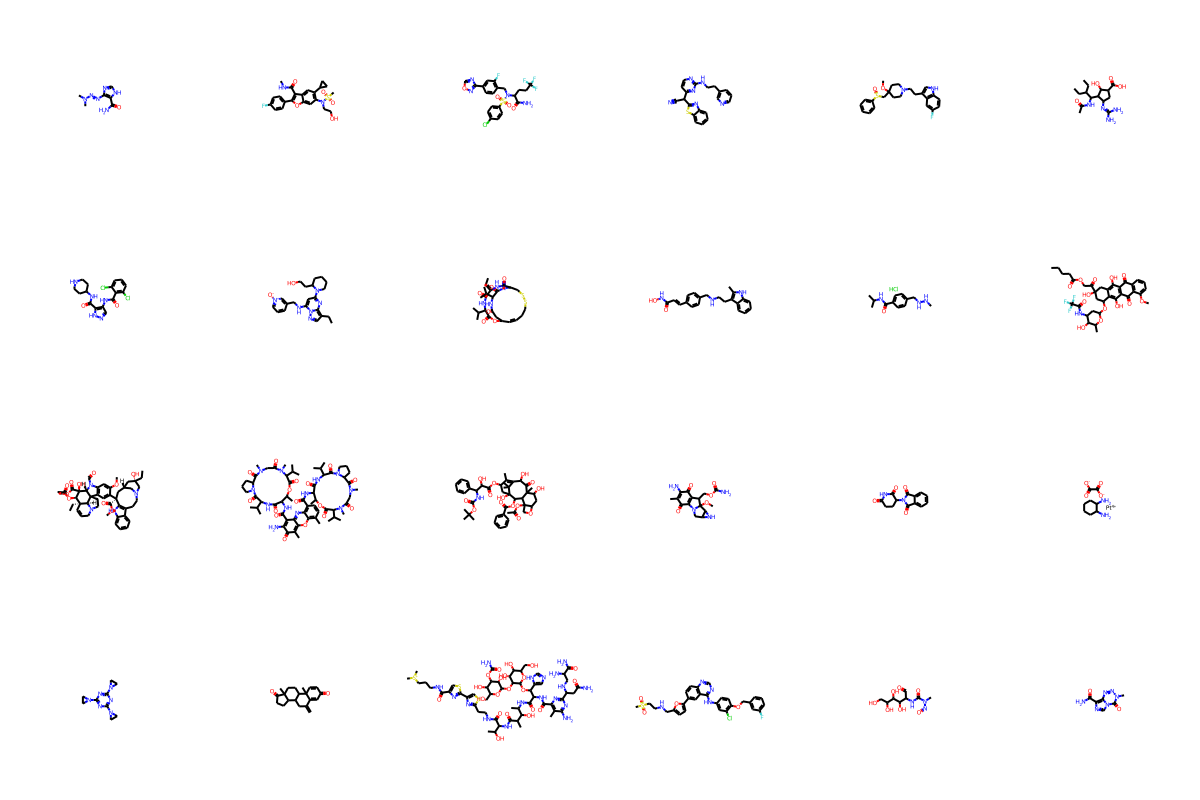

In [26]:
Draw.MolsToGridImage(uniq_mol.Mol.head(24), molsPerRow=6)

In [27]:
uniq_mol.iloc[0].DataOGB

Data(edge_index=[2, 26], edge_attr=[26, 3], x=[13, 9])

In [28]:
if (data_fname == 'data_v2'): #baseline model
    uniq_mol['xFlat'] = [torch.mean(torch.clone(data.x).type(torch.float32), dim=0) for data in uniq_mol['DataOGB']]

In [29]:
# uniq_mol.iloc[0].DataOGB.x

In [30]:
y = data.Y.copy()
y

0        0
1        0
2        0
3        1
4        0
        ..
25752    0
25753    0
25754    0
25755    1
25756    1
Name: Y, Length: 25757, dtype: int64

In [31]:
y.value_counts()

0    14847
1    10910
Name: Y, dtype: int64

In [32]:
ReaderWriter.dump_data(y.values, os.path.join(targetdata_dir_raw, 'y.pkl'))

In [33]:
# y_weights = compute_class_weights(torch.tensor(y))
# y_weights

In [34]:
# ReaderWriter.dump_data(y_weights, os.path.join(targetdata_dir_raw, 'y_weights.pkl'))

In [35]:
df_rma_landm.shape

(908, 1021)

In [36]:
expression = np.array([df_rma_landm['DATA.'+ str(c)].values for c in data["Cosmic_ID"]])
expression.shape

(25757, 908)

In [37]:
df_rma_landm

,Unnamed: 0,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
2,19,BAD,BCL2-associated agonist of cell death [Source:...,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
3,20,LAP3,leucine aminopeptidase 3 [Source:HGNC Symbol;A...,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
4,28,SNX11,sorting nexin 11 [Source:HGNC Symbol;Acc:14975],4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,17083,PLEKHM1,"pleckstrin homology domain containing, family ...",6.167946,5.271099,5.784561,7.587263,6.479184,5.700915,6.617353,...,6.714959,6.368537,8.252268,6.436644,6.436742,5.551436,5.634834,7.083564,5.776658,6.306988
904,17400,MIF,macrophage migration inhibitory factor (glycos...,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
905,17444,PRAF2,"PRA1 domain family, member 2 [Source:HGNC Symb...",5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205
906,17575,LYN,v-yes-1 Yamaguchi sarcoma viral related oncoge...,5.892532,4.580184,6.482469,7.094195,7.932918,7.333405,10.455397,...,4.914232,9.453552,3.218797,4.073831,6.355383,8.348965,7.579339,4.456322,5.857488,3.013612


In [38]:
# scaler = StandardScaler()
# pipeline = compose(scaler.fit_transform, np.tanh, scaler.fit_transform)

In [39]:
# expression_norm = pipeline(expression)
# expression_norm

In [40]:
# ReaderWriter.dump_data(expression_norm, os.path.join(targetdata_dir_raw, 'expression.pkl'))
ReaderWriter.dump_data(expression, os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [41]:
pairs = {i:(row.Drug1_ID, row.Drug2_ID) for i, row in data.iterrows()}
len(pairs)

25757

In [42]:
pairs

{0: ('dacarbazine', '717906-29-1'),
 1: ('Nesbuvir', '717906-29-1'),
 2: ('Avagacestat', '717906-29-1'),
 3: ('AS601245', '717906-29-1'),
 4: ('CHEMBL166161', '717906-29-1'),
 5: ('NCGC00346433-01', '717906-29-1'),
 6: ('AT7519', 'PF-3758309'),
 7: ('ZINC34894448', 'PF-3758309'),
 8: ('Romidepsin', 'thapsigargin'),
 9: ('CHEMBL2141644', 'thapsigargin'),
 10: ('Procarbazine hydrochloride', 'TOPOTECAN HYDROCHLORIDE'),
 11: ('Antibiotic AD 32', 'Eloxatin (TN) (Sanofi Synthelab)'),
 12: ('Vincristine sulfate', 'Lapatinib'),
 13: ('actinomycin D', 'Tamoxifen citrate'),
 14: ('docetaxel', 'Lapatinib'),
 15: ('mitomycin C', 'TOPOTECAN HYDROCHLORIDE'),
 16: ('thalidomide', 'Zanosar'),
 17: ('Eloxatin (TN) (Sanofi Synthelab)', 'ifosfamide'),
 18: ('Antibiotic AD 32', 'Co-V'),
 19: ('Triethylenemelamine', 'Sorafenib'),
 20: ('EXEMESTANE', 'amifostine'),
 21: ('bleomycin', 'Fulvestrant'),
 22: ('Lapatinib', '6-Mercaptopurine'),
 23: ('thalidomide', 'TOPOTECAN HYDROCHLORIDE'),
 24: ('Vincristine s

In [43]:
ReaderWriter.dump_data(pairs, os.path.join(targetdata_dir_raw, 'pairs.pkl'))

In [44]:
ReaderWriter.dump_data(data, os.path.join(targetdata_dir_raw, 'data_pairs.pkl'))

In [45]:
%%time

if (data_fname == 'data_v1'): #gnn model
    X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy,
                              data_gen_params=(uniq_mol, pairs, "DataOGB"))
    
if (data_fname == 'data_v2'): #baseline model
    X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X_flat.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy_flat,
                              data_gen_params=(uniq_mol, pairs, "xFlat"))

CPU times: user 4.6 s, sys: 21.1 ms, total: 4.62 s
Wall time: 4.63 s


In [46]:
%%time

# In order to generate a new Dataset, first remove the generated files above

dataset = MoleculeDataset(root=targetdata_dir, dataset='tdcSynergy')

Processing...
/cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/deepadr/dataset.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  data.expression = torch.tensor([expression[i]], dtype=torch.float32)
Done!


CPU times: user 3.2 s, sys: 1.25 s, total: 4.44 s
Wall time: 13.9 s


In [47]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MoleculeDataset(25757):
Number of graphs: 25757
Number of features: 9
Number of classes: 2


In [48]:
data0 = dataset[0]  # Get the first graph object.
data0

PairData(edge_index_a=[2, 26], x_a=[13, 9], edge_attr_a=[26, 3], edge_index_b=[2, 76], x_b=[35, 9], edge_attr_b=[76, 3], id=[1], y=[1], expression=[1, 908])

In [54]:
dataset.data.expression

tensor([[7.3013, 4.1251, 7.1277,  ..., 4.4361, 6.3370, 6.6896],
        [7.3013, 4.1251, 7.1277,  ..., 4.4361, 6.3370, 6.6896],
        [7.3013, 4.1251, 7.1277,  ..., 4.4361, 6.3370, 6.6896],
        ...,
        [7.1871, 3.5130, 7.6483,  ..., 3.6550, 6.8683, 6.7297],
        [7.1871, 3.5130, 7.6483,  ..., 3.6550, 6.8683, 6.7297],
        [7.1871, 3.5130, 7.6483,  ..., 3.6550, 6.8683, 6.7297]])

In [50]:
len(dataset)

25757